In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_moons

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
## Loading the moons data

data = make_moons(n_samples=500, noise=0.30, random_state=26)
X = data[0]
Y = data[1]

In [3]:
## train_test_split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=26)

In [4]:
# Weak learners

rf_clf = RandomForestClassifier(n_estimators=100, random_state=26)
svc = SVC(gamma='scale', random_state=26)
log_clf = LogisticRegression(solver='lbfgs', random_state=26)

In [5]:
# Voting classifier

voting_clf = VotingClassifier(estimators=[('logistic', log_clf), ('random forest', rf_clf),
                                         ('svc', svc)], voting='hard')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=26)),
                             ('random forest',
                              RandomForestClassifier(random_state=26)),
                             ('svc', SVC(random_state=26))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, svc, rf_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.94
SVC 0.94
RandomForestClassifier 0.96
VotingClassifier 0.94


#### => Didn't outperformed much here but it generally does!

### # Soft Voting:

If all classifiers are able to estimate class probabilities (**predict_proba() method**), then we can tell sci-kit learn to predict the class with the highest class probability, averaged over all individual classifiers. This is called **soft voting**.

In [7]:
svc_new = SVC(gamma='scale', probability=True, random_state=26)

"""
To implement the predict_proba method for the SVC we need to set its probability 
hyperparameter True.
"""

'\nTo implement the predict_proba method for the SVC we need to set its probability \nhyperparameter True.\n'

In [8]:
## New Voting classifier

voting_clf_new = VotingClassifier(estimators=[('logistic', log_clf), ('random forest', rf_clf),
                                         ('svc', svc_new)], voting='soft')
voting_clf_new.fit(x_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=26)),
                             ('random forest',
                              RandomForestClassifier(random_state=26)),
                             ('svc', SVC(probability=True, random_state=26))],
                 voting='soft')

In [9]:
## Computing accuracy for the new Voting Classifier

for clf in (log_clf, svc_new, rf_clf, voting_clf_new):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.94
SVC 0.94
RandomForestClassifier 0.96
VotingClassifier 0.94


### # Bagging and Pasting

Unlike Voting Classifiers, the Bagging ones performs **soft voting** instead of hard voting if the base classifier can estimate class probablities.

#### Bag of Decision Trees

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100,
                           bootstrap=True, n_jobs=-1)
bag_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [11]:
## Computing accuracy in the test set

y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.94

#### by setting `oob_score = True`
To request an automatic oob evaluation after training.

In [12]:
bag_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True,
                            oob_score=True)
bag_clf2.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  oob_score=True)

In [13]:
## oob_score

bag_clf2.oob_score_

0.8733333333333333

### # Random Forests

Ensemble of decision trees.

The random forests introduces **extra randomness** when growing trees; insetead of earching for the best features among all to be the root node, it chooses the best feature among a random subset of features.

**The algo results in greater tree diversity, which (again) trades a higher bias for a lower-variance, generally yielding an overall better model.**

In [14]:
## random forest

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [15]:
## performance

y_pred_rf = rnd_clf.predict(x_test)
accuracy_score(y_test, y_pred_rf)

0.94

A random forest is equivalent to a bag of decision trees.

In [16]:
bag_clf3 = BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
                            n_estimators=500, random_state=42)
bag_clf3.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt',
                                                        max_leaf_nodes=16),
                  n_estimators=500, random_state=42)

In [17]:
## performance

y_pred_bag = bag_clf3.predict(x_test)
accuracy_score(y_test, y_pred_bag)

0.94

### # Feature Importances via Random Forests

Yet another quality of randim forests is that **they make it easy to measure the relative importance of each feature.**

Sci-kit learn's measures a feature's importance by looking at **how much the tree nodes that use that feature, reduce the impurity on average** (across all trees in forest).

Scikit learn computes this score autiatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.

In [18]:
rnd_clf.feature_importances_

array([0.42936642, 0.57063358])

=> So here in the moons dataset, the contribution of second feature is tad more than the first.

In [19]:
## let's try on any Iris dataset
from sklearn.datasets import load_iris

data = load_iris()
X_iris = data["data"]
Y_iris = data["target"]

In [20]:
## train test split

x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, Y_iris, 
                                                                        test_size=0.15, 
                                                                        random_state=26)

In [21]:
## Random classifier

rnd_clf_iris = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf_iris.fit(x_train_iris, y_train_iris)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

#### Feature importances

In [22]:
for name, feature_score in zip(data.feature_names, rnd_clf_iris.feature_importances_):
    print(name, feature_score)

sepal length (cm) 0.10616312201374054
sepal width (cm) 0.024834881233378906
petal length (cm) 0.40795079181733346
petal width (cm) 0.4610512049355472


=> Most important features are `petal length` (45%) and `petal width` (42%); `sepal width` (2%) contributes the least.

## # Boosting Algorithms

* ### AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

In [24]:
## traning the classifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                            algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [25]:
## gauging its performance

y_pred_ada = ada_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.94

* ### Gradient Boosting

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble with each predictor working on the mistakes its predecessor.

**However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predctor to the `residuals` made by the previous predictors.**

In [51]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np

In [83]:
np.random.seed(26)
X = np.random.rand(100, 1) - .5
Y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

df = pd.DataFrame(np.c_[X, Y], columns=["X", "Y"])

In [84]:
df.head()

,X,Y
0,-0.192065,0.104473
1,0.019391,0.001823
2,0.268298,0.279503
3,0.289221,0.219032
4,0.370562,0.364310


In [85]:
import plotly.express as px

px.scatter(df, x="X", y="Y")

### # Let's try the approach manually first:

#### Tree 1:

In [86]:
tree1 = DecisionTreeRegressor(max_depth=2)
tree1.fit(X, Y)

DecisionTreeRegressor(max_depth=2)

In [87]:
y_pred1 = tree1.predict(X)
residuals1 = df.Y - y_pred1

#### Tree 2:

In [88]:
## Let's train the second decsion tree on the residuals computed by the first

tree2 = DecisionTreeRegressor(max_depth=2)
tree2.fit(X, residuals1)

DecisionTreeRegressor(max_depth=2)

#### Tree 3:

In [89]:
## Third decision tree to be trained on the predictions (residuals) given by the second

residuals2 = residuals1 - tree2.predict(X)
tree3 = DecisionTreeRegressor(max_depth=2)
tree3.fit(X, residuals2)

DecisionTreeRegressor(max_depth=2)

=> Now we got ensemble containing 3 trees. **It can make predictions on a new instance simply by adding up the predictions of all trees.**

In [90]:
X_new = np.array([[.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree1, tree2, tree3))
y_pred

array([0.68855564])

### GradientBoostRegressor

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X, Y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

### # Eta (learning rate):
The **learning_rate** hyperparameter **scales the contribution of each tree.**

**If set to low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better.** This is a regularization technique called **shrinkage**.

### # Let's see how we can find the optimal number of trees in Gradient Boosting: 

using staged_predict()

In [94]:
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(X, Y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [101]:
errors = [np.sqrt(mean_squared_error(y_test, y_pred)) for y_pred in gbrt.staged_predict(x_test)]
errors

[0.19435927589975885,
 0.1785687494173279,
 0.16492844352815728,
 0.15228270539259176,
 0.14058767213699205,
 0.13020569710738114,
 0.12284566849887238,
 0.11473596033564896,
 0.10847930820844892,
 0.1023981226839047,
 0.09720318018722195,
 0.09190668003970619,
 0.088243764903927,
 0.08519813169735857,
 0.08159313283552459,
 0.07857951915564879,
 0.07833338612436631,
 0.07730680918145466,
 0.07616063137999635,
 0.07521455290949364,
 0.07452615304473129,
 0.07271436884594534,
 0.07228938912903336,
 0.07060134740460065,
 0.06973909439330708,
 0.06834542017844805,
 0.06809276775675394,
 0.06748768216514489,
 0.06677871203476117,
 0.06538704234140114,
 0.06542567272826925,
 0.06462785019429675,
 0.06360204383493716,
 0.06269115294957366,
 0.06228787818213155,
 0.06178302912728525,
 0.061828472689653004,
 0.06195378921004527,
 0.06157483734884771,
 0.061040803223866416,
 0.06096545116204678,
 0.06071776810959408,
 0.06032437756996817,
 0.05984694428532692,
 0.059517251055978174,
 0.05942565

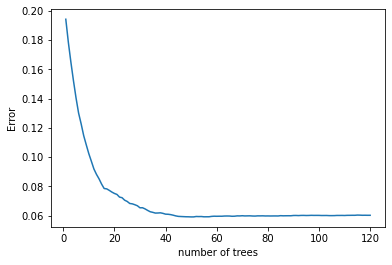

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.lineplot(x=np.array(range(1, 121)), y=np.array(errors))
plt.xlabel("number of trees")
plt.ylabel("Error")
plt.show()

=> So just like this we can determine the optimal number of trees needed to train a gradient boosting algorithm.

### # An easy alternative:

set **warm_start** = True

=> Makes Scikit Learn keep existing trees when the fit() methiod is called, allowing increemental training.

In [111]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimator in range(1, 120):
    gbrt.n_estimators = n_estimator
    gbrt.fit(x_train, y_train)
    y_pred = gbrt.predict(x_test)
    val_error = mean_squared_error(y_test, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [112]:
gbrt

GradientBoostingRegressor(max_depth=2, n_estimators=55, warm_start=True)